# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/MyDrive/mlproject")

In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.8 MB/s 
     |████████████████████████████████| 5.8 MB 33.4 MB/s 
     |████████████████████████████████| 1.3 MB 56.9 MB/s 
     |████████████████████████████████| 182 kB 73.6 MB/s 
     |████████████████████████████████| 7.6 MB 59.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=c6cb87bc0b25f85f99f370310822bdb243cb71ec30b4443e4ef71051288486ab
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import string

from multiprocessing import  Pool
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer, util
from sentence_transformers import util
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture
import pickle


import torch

In [ ]:
#read data from .tsv files
import pandas as pd
df_all_authors = pd.read_csv("all_authors.tsv", sep='\t', encoding= 'ISO-8859-1')
df_all_publications = pd.read_csv("all_publications.tsv", sep='\t')
df_selected_author_publications = pd.read_csv("selected_author_publications_information.tsv", sep='\t')
df_selected_publication_citations = pd.read_csv("selected_publication_citations_information.tsv", sep='\t')

In [ ]:
# Drop duplicates
df_all_publications.drop_duplicates(inplace=True)
df_selected_publication_citations.drop_duplicates(inplace=True)

# Drop NA's
#
print(df_all_publications.isna().sum())
print(df_selected_publication_citations.isna().sum())
df_selected_publication_citations.drop(['citation_sentence_cited'], axis=1, inplace=True)
df_all_publications.dropna(inplace=True)
print(df_all_publications.isna().sum())

paper_id                         0
paper_dblp_key                   0
paper_title                      0
paper_filtered_title             0
paper_published_date             0
paper_published_conference       0
paper_gscholar_url               0
paper_dblp_url                   0
paper_abstract                2529
dtype: int64
citing_paper_id                   0
cited_paper_id                    0
citation_title                    0
citation_filtered_title           0
citation_sentence_before       3843
citation_sentence_cited          25
citation_sentence_after        3391
citation_position (section)       0
dtype: int64
paper_id                      0
paper_dblp_key                0
paper_title                   0
paper_filtered_title          0
paper_published_date          0
paper_published_conference    0
paper_gscholar_url            0
paper_dblp_url                0
paper_abstract                0
dtype: int64


In [ ]:
titles    = []
abstracts = []
confs      = []
citeds    = []
cited_confs = []
cited_abs = []

for cited_idx, title in enumerate(df_selected_publication_citations['citation_filtered_title']):
    paper_id_found = False
    cited_paper_id = df_selected_publication_citations['cited_paper_id'].iloc[cited_idx]   
    paper_id = df_selected_publication_citations["citing_paper_id"].iloc[cited_idx]

    # All publications has not contain paper information for paper_id = 5835
    try:
        citeds.append(title)
        titles.append(df_all_publications['paper_title'].iloc[df_all_publications.index[df_all_publications['paper_id'] == paper_id].tolist()[0]])
        abstracts.append(df_all_publications['paper_abstract'].iloc[df_all_publications.index[df_all_publications['paper_id'] == paper_id].tolist()[0]])
        confs.append(df_all_publications['paper_published_conference'].iloc[df_all_publications.index[df_all_publications['paper_id'] == paper_id].tolist()[0]])
        paper_id_found = True
        cited_confs.append(df_all_publications['paper_published_conference'].iloc[df_all_publications.index[df_all_publications['paper_id'] == cited_paper_id].tolist()[0]])
        cited_abs.append(df_all_publications['paper_abstract'].iloc[df_all_publications.index[df_all_publications['paper_id'] == cited_paper_id].tolist()[0]])
    except:
        if paper_id_found:
            titles.pop()
            abstracts.pop()
            confs.pop()
            citeds.pop()
        continue

In [ ]:
headers = ['paper_title', 'paper_abstract', 'paper_published_conference', 'cited_paper_title', 'cited_paper_published_conference', 'cited_paper_abstract']
df = pd.DataFrame(list(zip(titles, abstracts, confs, citeds, cited_confs, cited_abs)),
               columns = headers)

df['paper_abstract'] = df['paper_abstract'].astype(str).map(lambda x: x.lstrip('[').rstrip(']'))
df['cited_paper_abstract'] = df['cited_paper_abstract'].astype(str).map(lambda x: x.lstrip('[').rstrip(']'))

train_set = df.sample(frac = 0.7)
test_set  = df.drop(train_set.index)

# Check the ratio
print(df.shape)
print(train_set.shape[0] / df.shape[0])
print(test_set.shape[0] / df.shape[0])

df.head(5)
train_set.head(5)

In [ ]:
train_set.to_csv("train_set.tsv", sep='\t')
test_set.to_csv("test_set.tsv", sep='\t')

In [ ]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

print(len(stopwords))

350


In [ ]:
parser = spacy.load("en_core_web_sm")
parser.max_length = 7000000

def call_tokenizer(df):
    df["paper_abstract"] = df["paper_abstract"].apply(spacy_tokenizer)
    df["paper_title"] = df["paper_title"].apply(spacy_tokenizer)
    return df

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    df = pd.DataFrame(df)
    return df

In [ ]:
loaded_train_set = pd.read_csv("train_set.tsv", sep='\t')
loaded_test_set = pd.read_csv("test_set.tsv", sep='\t')

In [ ]:
corpus = pd.concat([loaded_train_set, loaded_test_set], ignore_index=True)

In [ ]:
corpus = pd.DataFrame(corpus)

In [ ]:
corpus = corpus[['paper_title', 'paper_abstract']]

In [ ]:
corpus = corpus.drop_duplicates(["paper_title"])

In [ ]:
corpus.reset_index(drop=True, inplace=True)

In [ ]:
%time corpus = parallelize_dataframe(df=corpus, func=call_tokenizer, n_cores=50)

CPU times: user 809 ms, sys: 1.93 s, total: 2.74 s
Wall time: 1min 52s


In [ ]:
corpus.head()

,paper_title,paper_abstract
0,potential base difference reward multiagent re...,difference reward potential base reward shapin...
1,network virtualization wdm flexible grid optic...,network virtualization eradicate ossification ...
2,private capacities mechanism design,algorithmic mechanism design consider distribu...
3,applied thermodynamics grain boundary segregation,chemical composition interface free surface gr...
4,filter raster signature,efficient evaluation spatial query important i...


# Model : msmarco-distilbert-base-v4

## simple semantic search

In [ ]:
model_semantic_search = SentenceTransformer('msmarco-distilbert-base-v4')

#For other pre-trained models, please check link below:
#https://www.sbert.net/docs/pretrained_models.html

# For paper abstracts

# Model : msmarco-distilbert-base-v4
corpus_embeddings = model_semantic_search.encode(corpus["paper_abstract"],convert_to_tensor=True)
print(corpus_embeddings.shape)



torch.Size([2587, 768])


In [ ]:
model_semantic_search = SentenceTransformer('msmarco-distilbert-base-v4')

#For other pre-trained models, please check link below:
#https://www.sbert.net/docs/pretrained_models.html

# For paper abstracts

# Model : msmarco-distilbert-base-v4
query_embeddings = model_semantic_search.encode(corpus["paper_title"] ,convert_to_tensor=True )
print(query_embeddings.shape)

torch.Size([2587, 768])


In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

In [ ]:
corpus_embeddings_cuda = pd.DataFrame(corpus_embeddings)
query_embeddings_cuda = pd.DataFrame(query_embeddings)

In [ ]:
corpus_embeddings_cuda = corpus_embeddings.to('cuda')
query_embeddings_cuda = query_embeddings.to('cuda')

acc = 0
top_k = min(5, len(corpus))
for i in range(len(corpus)):
  query = corpus["paper_title"][i]
  query_embedding = query_embeddings_cuda[i]


  cos_scores = util.cos_sim(query_embedding, corpus_embeddings_cuda)[0]
  top_results = torch.topk(cos_scores, k=top_k)

  for score, idx in zip(top_results[0], top_results[1]):
    if i == idx.item():
      acc +=1

In [ ]:
acc/len(corpus)

0.6988790104367993

In [ ]:
top_k = min(5, len(corpus))
query = "	applied thermodynamics grain boundary segregation"
query_embedding = model_semantic_search.encode(query, convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", query)
print("\nTop 5 most similar sentences in corpus:")

for score, idx in zip(top_results[0], top_results[1]):

    print(idx.item())
    print(corpus["paper_abstract"][idx.item()], "(Score: {:.4f})".format(score))





Query: 	applied thermodynamics grain boundary segregation

Top 5 most similar sentences in corpus:
3
chemical composition interface free surface grain boundary generally describe langmuir mclean segregation isotherm control gibbs energy segregation component gibbs energy segregation standard excess thermodynamic state function enthalpy entropy volume interfacial segregation derive physical meaning elucidated importance thermodynamic state function grain boundary segregation dependence volume solid solubility mutual solute solute interaction pressure effect ferrous alloy demonstrate (Score: 0.5456)
1005
paper propose unsupervised boundary detection algorithm improved surround suppression model base orientation contrast fir t candidate boundary set obtain edge focus algorithm second orientation contrast map construct use response ga bor filter suppression term compute orientation contrast map use steerable filter effectively differentiate step edge texture edge use low level image fe

## semantic search with pca

In [ ]:
#define scaler
scaler = StandardScaler()

corpus_embeddings_scaled = pd.DataFrame(scaler.fit_transform(corpus_embeddings.cpu()))
print(corpus_embeddings_scaled.shape)

query_embeddings_scaled = pd.DataFrame(scaler.fit_transform(query_embeddings.cpu()))
print(query_embeddings_scaled.shape)

(2587, 768)
(2587, 768)


In [ ]:
pca = PCA()
pca_corpus = pca.fit_transform((corpus_embeddings_scaled))
print('Cumulative variance explained by principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))
n_pcs= pca.components_.shape[0]
print("Number of principal components : {}". format(n_pcs))
print("Shape of principal components : {}". format(pca.components_.shape))

Cumulative variance explained by principal components: 100.00%
Number of principal components : 768
Shape of principal components : (768, 768)


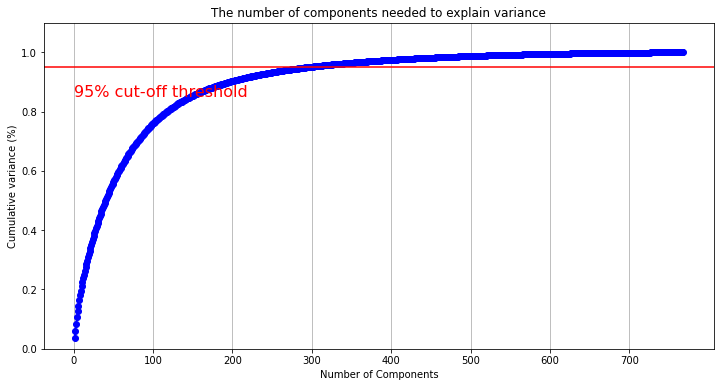

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, n_pcs+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n_pcs, step=100)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
principalComponents = pca.fit_transform(corpus_embeddings_scaled)
principalComponents.shape

(2587, 296)

In [ ]:
principalComponents_test = pca.transform(query_embeddings_scaled)

In [ ]:
corpus_embeddings_scaled_cuda = principalComponents
query_embeddings_scaled_cuda = principalComponents_test

acc = 0
top_k = min(5, len(corpus))
for i in range(len(corpus)):
  query = corpus["paper_title"][i]
  query_embedding = query_embeddings_scaled_cuda[i]


  cos_scores = util.cos_sim(query_embedding, corpus_embeddings_scaled_cuda)[0]
  top_results = torch.topk(cos_scores, k=top_k)

  for score, idx in zip(top_results[0], top_results[1]):
    if i == idx.item():
      acc +=1

In [ ]:
acc/len(corpus)

0.761886354851179

In [ ]:
corpus_embeddings_scaled_cuda = principalComponents
top_k = min(5, len(corpus))
query = ["applied thermodynamics grain boundary segregation"]
query_embedding = model_semantic_search.encode(query, convert_to_tensor=True)
query_embedding = pca.transform(query_embedding.cpu())
# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings_scaled_cuda)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", query)
print("\nTop 5 most similar sentences in corpus:")

for score, idx in zip(top_results[0], top_results[1]):

    print(idx.item())
    print(corpus["paper_abstract"][idx.item()], "(Score: {:.4f})".format(score))





Query: ['applied thermodynamics grain boundary segregation']

Top 5 most similar sentences in corpus:
3
chemical composition interface free surface grain boundary generally describe langmuir mclean segregation isotherm control gibbs energy segregation component gibbs energy segregation standard excess thermodynamic state function enthalpy entropy volume interfacial segregation derive physical meaning elucidated importance thermodynamic state function grain boundary segregation dependence volume solid solubility mutual solute solute interaction pressure effect ferrous alloy demonstrate (Score: 0.5731)
1005
paper propose unsupervised boundary detection algorithm improved surround suppression model base orientation contrast fir t candidate boundary set obtain edge focus algorithm second orientation contrast map construct use response ga bor filter suppression term compute orientation contrast map use steerable filter effectively differentiate step edge texture edge use low level image